# Часть 1: анализ ридов Illumina

## 0. Разобраться с Bowtie2

In [9]:
# готовим индексы
!bowtie2-build test1_data/MG1655-K12.fasta test1_data/genome_ecoli

Settings:
  Output files: "test1_data/genome_ecoli.*.bt2"
  Line rate: 6 (line is 64 bytes)
  Lines per side: 1 (side is 64 bytes)
  Offset rate: 4 (one in 16)
  FTable chars: 10
  Strings: unpacked
  Max bucket size: default
  Max bucket size, sqrt multiplier: default
  Max bucket size, len divisor: 4
  Difference-cover sample period: 1024
  Endianness: little
  Actual local endianness: little
  Sanity checking: disabled
  Assertions: disabled
  Random seed: 0
  Sizeofs: void*:8, int:4, long:8, size_t:8
Input files DNA, FASTA:
  test1_data/MG1655-K12.fasta
Building a SMALL index
Reading reference sizes
  Time reading reference sizes: 00:00:01
Calculating joined length
Writing header
Reserving space for joined string
Joining reference sequences
  Time to join reference sequences: 00:00:00
bmax according to bmaxDivN setting: 1159918
Using parameters --bmax 869939 --dcv 1024
  Doing ahead-of-time memory usage test
  Passed!  Constructing with these parameters: --bmax 869939 --dcv 1024
Co

In [11]:
!bowtie2 -S test1_data/ecoli_1.sam -x test1_data/genome_ecoli -1 test1_data/100x.1.fastq -2 test1_data/100x.2.fastq 

2500000 reads; of these:
  2500000 (100.00%) were paired; of these:
    21263 (0.85%) aligned concordantly 0 times
    2413019 (96.52%) aligned concordantly exactly 1 time
    65718 (2.63%) aligned concordantly >1 times
    ----
    21263 pairs aligned concordantly 0 times; of these:
      551 (2.59%) aligned discordantly 1 time
    ----
    20712 pairs aligned 0 times concordantly or discordantly; of these:
      41424 mates make up the pairs; of these:
        25433 (61.40%) aligned 0 times
        15044 (36.32%) aligned exactly 1 time
        947 (2.29%) aligned >1 times
99.49% overall alignment rate


In [12]:
# смотрим на статистику по первой пачке ридов
!samtools flagstat test1_data/ecoli_1.sam

5000000 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
4974567 + 0 mapped (99.49% : N/A)
5000000 + 0 paired in sequencing
2500000 + 0 read1
2500000 + 0 read2
4957474 + 0 properly paired (99.15% : N/A)
4959050 + 0 with itself and mate mapped
15517 + 0 singletons (0.31% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


In [13]:
!bowtie2 -S test1_data/ecoli_2.sam -x test1_data/genome_ecoli -1 test1_data/ecoli_mda_lane1_left.downsampled.fastq -2 test1_data/ecoli_mda_lane1_right.downsampled.fastq 

2914383 reads; of these:
  2914383 (100.00%) were paired; of these:
    392147 (13.46%) aligned concordantly 0 times
    2438252 (83.66%) aligned concordantly exactly 1 time
    83984 (2.88%) aligned concordantly >1 times
    ----
    392147 pairs aligned concordantly 0 times; of these:
      103111 (26.29%) aligned discordantly 1 time
    ----
    289036 pairs aligned 0 times concordantly or discordantly; of these:
      578072 mates make up the pairs; of these:
        425681 (73.64%) aligned 0 times
        139197 (24.08%) aligned exactly 1 time
        13194 (2.28%) aligned >1 times
92.70% overall alignment rate


In [14]:
# смотрим на статистику по первой пачке ридов
!samtools flagstat test1_data/ecoli_2.sam

5828766 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
5403085 + 0 mapped (92.70% : N/A)
5828766 + 0 paired in sequencing
2914383 + 0 read1
2914383 + 0 read2
5044472 + 0 properly paired (86.54% : N/A)
5261870 + 0 with itself and mate mapped
141215 + 0 singletons (2.42% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


## 1. Покрытие генома.

In [7]:
import matplotlib.pyplot as plt
import pysam
import numpy as np
from Bio import SeqIO
import numpy as np
import scipy.stats as ss
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.linear_model import Ridge
from IPython.display import set_matplotlib_formats
import seaborn as sns
set_matplotlib_formats('svg')
%matplotlib inline
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 12.
plt.rcParams["figure.figsize"] = [8., 5.]

In [8]:
def get_genome_seq(path):
    return next(SeqIO.parse(path, "fasta")).seq

In [3]:
"""
path_sam -- path of sam file for analyze
len_genome -- length of genome corresponding sam-file

Returns: np.array that represent distribution of coverage by each position

"""
def get_dist_coverage(path_sam, len_genome):
    samfile = pysam.AlignmentFile(path_sam, "rb")
    dist = np.zeros(len_genome)
    for read in samfile.fetch():
        blocks = read.get_blocks()
        for (l, r) in blocks:
            dist[l:r] += 1
    samfile.close()
    return dist

In [4]:
def print_stats(dist_coverage):
    mean_coverage = dist_coverage.mean()
    percent_non_zero_coverage = (dist_coverage.size - dist_coverage[dist_coverage == 0].size) / dist_coverage.size
    print(f"Среднее покрытие: {mean_coverage}")
    print(f"Доля покрытой области генома: {percent_non_zero_coverage}")

In [5]:
def get_mean_array(arr, num_buckets=1000):
    size_bucket = int(arr.size / num_buckets)
    mean_arr = np.zeros(num_buckets)
    for (idx, i) in enumerate(range(0, arr.size - size_bucket, size_bucket)):
        mean_arr[idx] = np.mean(arr[i: i + size_bucket])
    return mean_arr

In [6]:
def get_graph_distr(dist, title, x_name, y_name):
    num_buckets = 1000
    size_bucket = int(dist.size / num_buckets)
    mean_dist = get_mean_array(dist, num_buckets)
    positions = np.array(range(0, dist.size - size_bucket, size_bucket))  
    plt.title(title)   
    plt.xlabel(x_name)   
    plt.ylabel(y_name)   
    plt.plot(positions, mean_dist)   
    plt.show()
    sns.barplot(x=positions, y=mean_dist)

In [7]:
# read genome's ecoli
genome_ecoli = get_genome_seq("test1_data/MG1655-K12.fasta")
len_genome_ecoli = len(genome_ecoli)

#### ecoli_1

In [8]:
ecoli_1_sam = "test1_data/ecoli_1.sam"
ecoli_1_dist_coverage = get_dist_coverage(ecoli_1_sam, len_genome_ecoli)

In [9]:
print_stats(ecoli_1_dist_coverage)

Среднее покрытие: 107.21229525774973
Доля покрытой области генома: 1.0


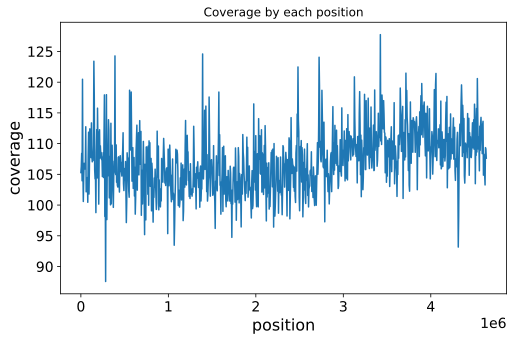

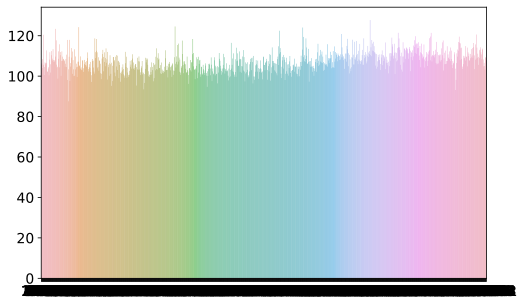

In [10]:
get_graph_distr(ecoli_1_dist_coverage, title='Coverage by each position', x_name='position', y_name='coverage')

#### ecoli_2

In [11]:
ecoli_2_sam = "test1_data/ecoli_2.sam"
ecoli_2_dist_coverage = get_dist_coverage(ecoli_2_sam, len_genome_ecoli)

In [12]:
print_stats(ecoli_2_dist_coverage)

Среднее покрытие: 116.33461998954668
Доля покрытой области генома: 0.9640470507093708


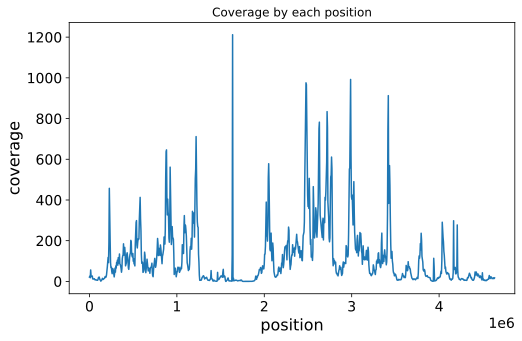

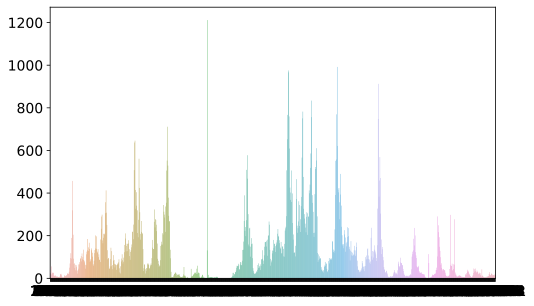

In [13]:
get_graph_distr(ecoli_2_dist_coverage, title='Coverage by each position', x_name='position', y_name='coverage')

## 2. Распределение расстояния вставки.

In [9]:
def read_insert_size_distribution(filename, max_tlen=1000):
    dict_is = np.zeros(max_tlen, dtype=int)
    max_is = 0
    with open(filename, 'r') as file:
        for line in file:
            insert_size_str, pairs_total_str = line.split('\t')
            insert_size, pairs_total = int(insert_size_str), int(pairs_total_str)
            if insert_size >= max_tlen:
                continue
            max_is = max(max_is, insert_size)
            dict_is[insert_size] = pairs_total
    dict_is[0] = 0

    return dict_is[:(max_is + 1)]

In [10]:
def get_stat_tlens(dist_template_length):
    num_tlen = np.sum(dist_template_length)
    sum_template_length = np.sum(np.arange(dist_template_length.size) * dist_template_length)
    sum_template_length_sq = np.sum((np.arange(dist_template_length.size) ** 2) * dist_template_length)

    mean_template_length = sum_template_length / num_tlen
    std_template_length = np.sqrt(sum_template_length_sq / num_tlen - mean_template_length ** 2)
    return (mean_template_length, std_template_length)

def simple_removing_outliners(x, mean, std, max_tlen=1000):
    l = int(max(0, mean - 3 * std))
    r = int(min(mean + 3 * std, x.size))
    x[:l] = 0
    return x[:r]

In [19]:
def get_presum_reads(dist_template_length):
    presum = np.zeros(dist_template_length.size)
    for (i, el) in enumerate(dist_template_length):
        if i == 0:
            presum[i] = el
            continue
        presum[i] = presum[i - 1] + el
    
    return presum

# функция для нахождения интервала минимальной ширины в который входит 95% ридов
def print_min_interval(dist_template_length):
    presum = get_presum_reads(dist_template_length)
    min_num_for_95 = int(round(0.95 * presum[-1]))
    min_l, min_r = 0, dist_template_length.size - 1
    prev_end_pos = 0
    for start_pos in range(dist_template_length.size):
        for end_pos in range(prev_end_pos, dist_template_length.size):
            if presum[end_pos] - presum[start_pos] > min_num_for_95:
                prev_end_pos = end_pos
                if end_pos - start_pos < min_r - min_l:
                    min_l, min_r = start_pos, end_pos
                break
    print(f"Интервал минимальной ширины, в который попадает 95% ридов: ({min_l}, {min_r})")

In [29]:
def get_genome_seq(path):
    return next(SeqIO.parse(path, "fasta")).seq


def get_dict_by_numpy(arr):
    res = dict()
    for (i, el) in enumerate(arr):
        if el != 0:
            res[i] = el
    return res


def get_indices_all_homopolymers(genome, num_is_homo=3):
    res = []
    for i in range(len(genome) - num_is_homo):
        is_homo = True
        for j in range(i + 1, i + num_is_homo):
            if genome[j] != genome[j - 1]:
                is_homo = False
                break
        if is_homo:
            res.extend(list(range(i, i + num_is_homo)))
    return res

# Процент инделов, находящихся рядом с гомополимерными участками (много одинаковых нуклеотидов подряд)
# Гомополимерным участком считаем по крайней мере 3 одинаковых подряд нуклеотида
"""
:param
    path_sam - path to sam file
    genome - string, representing of genome

:returns indel distribution, percent of indels near homopolymer
"""
def get_dist_indels(path_sam, genome, indices_all_homopolymers, max_len_read=100000):
    samfile = pysam.AlignmentFile(path_sam, "rb")
    num_indels_near_homopolymer = 0
    num_indels = 0
    stat_quality_nucl_error_insert = np.zeros(200, dtype=int)
    stat_quality_nucl_mismatch = np.zeros(200, dtype=int)
    # init matrix
    matrix = dict()
    nucleotids = ['A', 'G', 'C', 'T', 'N', '_']
    for nucl1 in nucleotids:
        for nucl2 in nucleotids:
            matrix[(nucl1, nucl2)] = 0

    percent_errors = []
    for read in samfile.fetch():
        if read.query_sequence is None and read.is_primary():
            continue
        aligned_pairs = read.get_aligned_pairs()
        qualities = read.get_forward_qualities()

        num_error_in_read = 0
        prev_idx_reference = -1
        for (idx_read, idx_reference) in aligned_pairs:
            if idx_reference:
                prev_idx_reference = idx_reference
            if idx_read is None: # insertion
                if idx_reference in indices_all_homopolymers:
                    num_indels_near_homopolymer += 1
                num_error_in_read += 1
                num_indels += 1
                char_of_reference = genome[idx_reference]
                # update stat for deletion
                matrix[('_', char_of_reference)] += 1
            elif idx_reference is None: # deletion
                # update stat for insertion
                if prev_idx_reference != -1 and idx_reference in indices_all_homopolymers:
                    num_indels_near_homopolymer += 1
                num_indels += 1
                num_error_in_read += 1
                stat_quality_nucl_error_insert[qualities[idx_read]] += 1
                char_of_read = read.query_sequence[idx_read].upper()
                matrix[(char_of_read, '_')] += 1
            else: # match or mismatch
                char_of_read = read.query_sequence[idx_read].upper()
                char_of_reference = genome[idx_reference].upper()
                # update mismatch stat
                if char_of_read != char_of_reference:
                    num_error_in_read += 1
                    stat_quality_nucl_mismatch[qualities[idx_read]] += 1
                    matrix[(char_of_read, char_of_reference)] += 1
        if (len(aligned_pairs) != 0):
            percent_errors.append(num_error_in_read / len(aligned_pairs))

    samfile.close()

    stat_quality_nucl_error_insert = get_dict_by_numpy(stat_quality_nucl_error_insert)
    stat_quality_nucl_mismatch = get_dict_by_numpy(stat_quality_nucl_mismatch)
    mean_percent_errors = np.mean(percent_errors)
    for nucl in ['A', 'G', 'C', 'T', '_']:
        del matrix[('N', nucl)]
        del matrix[(nucl, 'N')]
    del matrix[('N', 'N')]

    return stat_quality_nucl_error_insert, stat_quality_nucl_mismatch, matrix, num_indels_near_homopolymer / num_indels, mean_percent_errors

#### ecoli_1

Получим распределение расстояния вставки с помощью `samtools stats`

In [18]:
!samtools stats test1_data/ecoli_1.sam | grep ^IS | cut -f 2,3 >ecoli_1_is.txt

In [13]:
ecoli_1_dist_template_length = read_insert_size_distribution("ecoli_1_is.txt")
mean_template_length_ecoli_1, std_template_length_ecoli_1 = get_stat_tlens(ecoli_1_dist_template_length)

Проведём простую фильтрацию распределения расстояния вставок

In [14]:
ecoli_1_dist_template_length = simple_removing_outliners(ecoli_1_dist_template_length, mean_template_length_ecoli_1, std_template_length_ecoli_1)

In [15]:
# Пересчитаем статистики
mean_template_length_ecoli_1, std_template_length_ecoli_1 = get_stat_tlens(ecoli_1_dist_template_length)
print(f"Среднее расстояние вставки: {mean_template_length_ecoli_1}")
print(f"Среднеквадратичное отклонение : {std_template_length_ecoli_1}")

Среднее расстояние вставки: 215.2053880608519
Среднеквадратичное отклонение : 9.841015166036298


In [20]:
print_min_interval(ecoli_1_dist_template_length)

Интервал минимальной ширины, в который попадает 95% ридов: (194, 232)


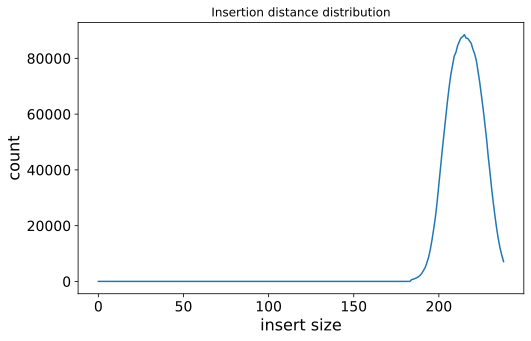

In [56]:
plt.title('Insertion distance distribution')   
plt.xlabel('insert size')   
plt.ylabel('count')   
plt.plot(np.arange(ecoli_1_dist_template_length.size), ecoli_1_dist_template_length)   
plt.show()

In [ ]:
#### ecoli_2

In [59]:
!samtools stats test1_data/ecoli_2.sam | grep ^IS | cut -f 2,3 >ecoli_2_is.txt

In [21]:
ecoli_2_dist_template_length = read_insert_size_distribution("ecoli_2_is.txt")
mean_template_length_ecoli_2, std_template_length_ecoli_2 = get_stat_tlens(ecoli_2_dist_template_length)

In [22]:
ecoli_2_dist_template_length = simple_removing_outliners(ecoli_2_dist_template_length, mean_template_length_ecoli_2, std_template_length_ecoli_2)

In [23]:
# пересчитаем статистики
mean_template_length_ecoli_2, std_template_length_ecoli_2 = get_stat_tlens(ecoli_2_dist_template_length)
print(f"Среднее расстояние вставки: {mean_template_length_ecoli_2}")
print(f"Среднеквадратичное отклонение : {std_template_length_ecoli_2}")

Среднее расстояние вставки: 263.08866325902784
Среднеквадратичное отклонение : 60.6679317564254


In [24]:
print_min_interval(ecoli_2_dist_template_length)

Интервал минимальной ширины, в который попадает 95% ридов: (108, 331)


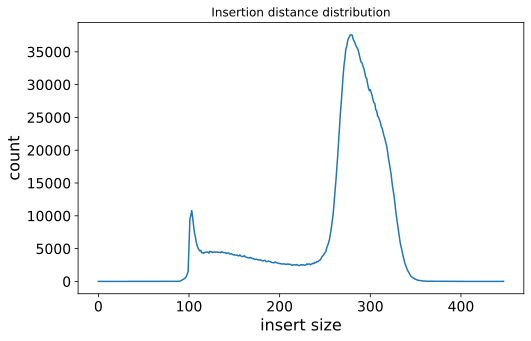

In [67]:
plt.title('Insertion distance distribution')   
plt.xlabel('insert size')   
plt.ylabel('count')   
plt.plot(np.arange(ecoli_2_dist_template_length.size), ecoli_2_dist_template_length)   
plt.show()

In [ ]:
# всё что больше 

## 3. Частоты различных замен

In [69]:
indices_all_homopolymers = get_indices_all_homopolymers(genome_ecoli)

In [33]:
def print_dict(d):
    for (i, el) in d.items():
        print(f'{i}  {el}')

#### ecoli_1

In [70]:
_, _, matrix_ecoli_1, _, mean_percent_errors_ecoli_1 = get_dist_indels(ecoli_1_sam, genome_ecoli, indices_all_homopolymers)

In [73]:
print(f"Средний процент ошибок в ридах: {mean_percent_errors_ecoli_1}")

print("Таблица частот замен/вставок/удалений:")
print_dict(matrix_ecoli_1)

Средний процент ошибок в ридах: 0.015676798077625655
Таблица частот замен/вставок/удалений:
('A', 'A')  0
('A', 'G')  356067
('A', 'C')  547886
('A', 'T')  330422
('A', '_')  4326
('G', 'A')  757057
('G', 'G')  0
('G', 'C')  630877
('G', 'T')  1100735
('G', '_')  8833
('C', 'A')  1103106
('C', 'G')  630990
('C', 'C')  0
('C', 'T')  752650
('C', '_')  8949
('T', 'A')  328867
('T', 'G')  548661
('T', 'C')  350930
('T', 'T')  0
('T', '_')  4328
('_', 'A')  1027
('_', 'G')  906
('_', 'C')  848
('_', 'T')  950
('_', '_')  0


#### ecoli_2

In [75]:
_, _, matrix_ecoli_2, _, mean_percent_errors_ecoli_2 = get_dist_indels(ecoli_2_sam, genome_ecoli, indices_all_homopolymers)

In [76]:
print(f"Средний процент ошибок в ридах: {mean_percent_errors_ecoli_2}")

print("Таблица частот замен/вставок/удалений:")
print_dict(matrix_ecoli_2)

Средний процент ошибок в ридах: 0.011449486276349233
Таблица частот замен/вставок/удалений:
('A', 'A')  0
('A', 'G')  238194
('A', 'C')  374021
('A', 'T')  243090
('A', '_')  134877
('G', 'A')  489274
('G', 'G')  0
('G', 'C')  331893
('G', 'T')  742680
('G', '_')  141404
('C', 'A')  755169
('C', 'G')  337720
('C', 'C')  0
('C', 'T')  494420
('C', '_')  142662
('T', 'A')  242029
('T', 'G')  369217
('T', 'C')  238806
('T', 'T')  0
('T', '_')  133333
('_', 'A')  10577
('_', 'G')  9976
('_', 'C')  10373
('_', 'T')  10699
('_', '_')  0


# Часть 2: анализ ридов IonTorrent

In [ ]:
!bwa index test_ion_data/data/DH10B-K12.fasta -p genome

In [ ]:
!bwa mem test_ion_data/data/genome test_ion_data/data/C24-698.fastq -o test_ion_data/data/file.sam

In [26]:
genome_ion_data = get_genome_seq("test_ion_data/data/DH10B-K12.fasta")
len_genome_ion_data = len(genome_ion_data)
indices_all_homopolymers_ion_data = get_indices_all_homopolymers(genome_ion_data)

In [27]:
ion_data_sam = "test_ion_data/data/file.sam"

In [ ]:
ion_data_dist_coverage = get_dist_coverage(ion_data_sam, len_genome_ecoli)

In [79]:
print_stats(ion_data_dist_coverage)

Среднее покрытие: 35.658215284475745
Доля покрытой области генома: 0.999999784467662


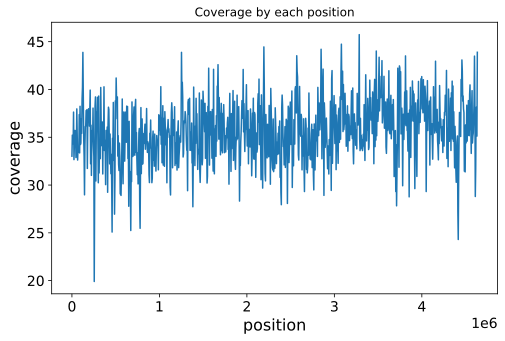

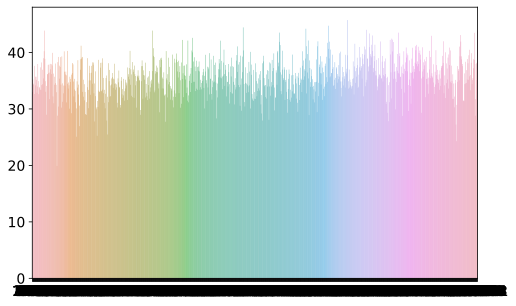

In [81]:
get_graph_distr(ion_data_dist_coverage, title='Coverage by each position', x_name='position', y_name='coverage')

In [30]:
stat_quality_nucl_error_insert, stat_quality_nucl_mismatch, matrix, percent_indels_near_homopol, mean_percent_errors = get_dist_indels(ion_data_sam, genome_ion_data, indices_all_homopolymers_ion_data)

In [31]:
# The columns are: length, number of insertions, number of deletions
print("Статистика длин инделов:")
!samtools stats test_ion_data/data/file.sam | grep ^ID | cut -f 2-

Статистика длин инделов:
1	222134	215400
2	13473	10236
3	1186	881
4	318	115
5	118	31
6	58	5
7	51	1
8	24	3
9	19	0
10	15	1
11	12	0
12	8	0
13	5	0
14	9	0
15	5	0
16	3	0
17	5	0
18	2	0
20	1	0
26	1	0


In [34]:
print(f"Процент инделов, находящихся рядом с гомополимерными участками : {percent_indels_near_homopol}")

print("Статистика качества нуклеотидов при ошибочно вставленном нуклеотиде:")
print_dict(stat_quality_nucl_error_insert)

print("Статистика качества нуклеотидов при замене:")
print_dict(stat_quality_nucl_mismatch)

print(f"Средний процент ошибок в ридах: {mean_percent_errors}")

print("Таблица частот замен/вставок/удалений:")
print_dict(matrix)

Процент инделов, находящихся рядом с гомополимерными участками : 0.1164551365534608
Статистика качества нуклеотидов при ошибочно вставленном нуклеотиде:
1  632
3  878
4  140
5  1648
6  220
7  7473
8  8416
9  35524
10  38824
11  85590
12  44059
13  54267
14  78216
15  50173
16  33077
17  13327
18  33833
19  49280
20  13377
21  18563
22  21606
23  21574
24  23676
25  11929
26  16490
27  11918
28  14463
29  10955
30  17805
31  22338
32  19493
33  19807
34  17159
35  2730
36  923
37  334
38  239
39  136
40  48
41  24
42  25
43  21
45  24
Статистика качества нуклеотидов при замене:
1  14
3  23
4  2
5  118
6  11
7  903
8  829
9  3986
10  4178
11  10035
12  4962
13  5412
14  9752
15  5436
16  5013
17  1111
18  2619
19  5866
20  1048
21  1555
22  2802
23  3589
24  4467
25  2435
26  3288
27  3151
28  3174
29  2841
30  4717
31  6165
32  5329
33  7433
34  6393
35  923
36  329
37  139
38  78
39  38
40  13
41  3
42  7
43  2
45  9
Средний процент ошибок в ридах: 0.008539395817146786
Таблица частот з